In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from nam.wrapper import NAMClassifier
import sklearn.metrics as sk_metrics
import seaborn as sns
from scipy.stats import gaussian_kde

c:\Users\arthe\anaconda3\envs\scbert_new\lib\site-packages\nam\trainer\trainer.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
#load data
X = pd.read_csv('data/data_preprocessed.csv').drop('Unnamed: 0', axis=1)
X_test = pd.read_csv('data/test_data_preprocessed.csv').drop('Unnamed: 0', axis=1)
y = pd.read_csv('data/outcome.csv')['HeartDisease']
y_test = pd.read_csv('data/outcome_test.csv')['HeartDisease']

In [3]:
random_state = 2016
NUMBER_OF_LEARNERS = 50
model = NAMClassifier(
            num_epochs=50,
            num_learners=NUMBER_OF_LEARNERS,
            metric='auroc',
            early_stop_mode='max',
            monitor_loss=False,
            n_jobs=10,
            random_state=random_state
        )

model.fit(X, y)

In [4]:
numerical_columns = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

In [9]:
X.columns

Index(['Age', 'Sex', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR',
       'ExerciseAngina', 'Oldpeak', 'ST_Slope', 'ChestPainType_ASY',
       'ChestPainType_ATA', 'ChestPainType_NAP', 'ChestPainType_TA',
       'RestingECG_LVH', 'RestingECG_Normal', 'RestingECG_ST'],
      dtype='object')

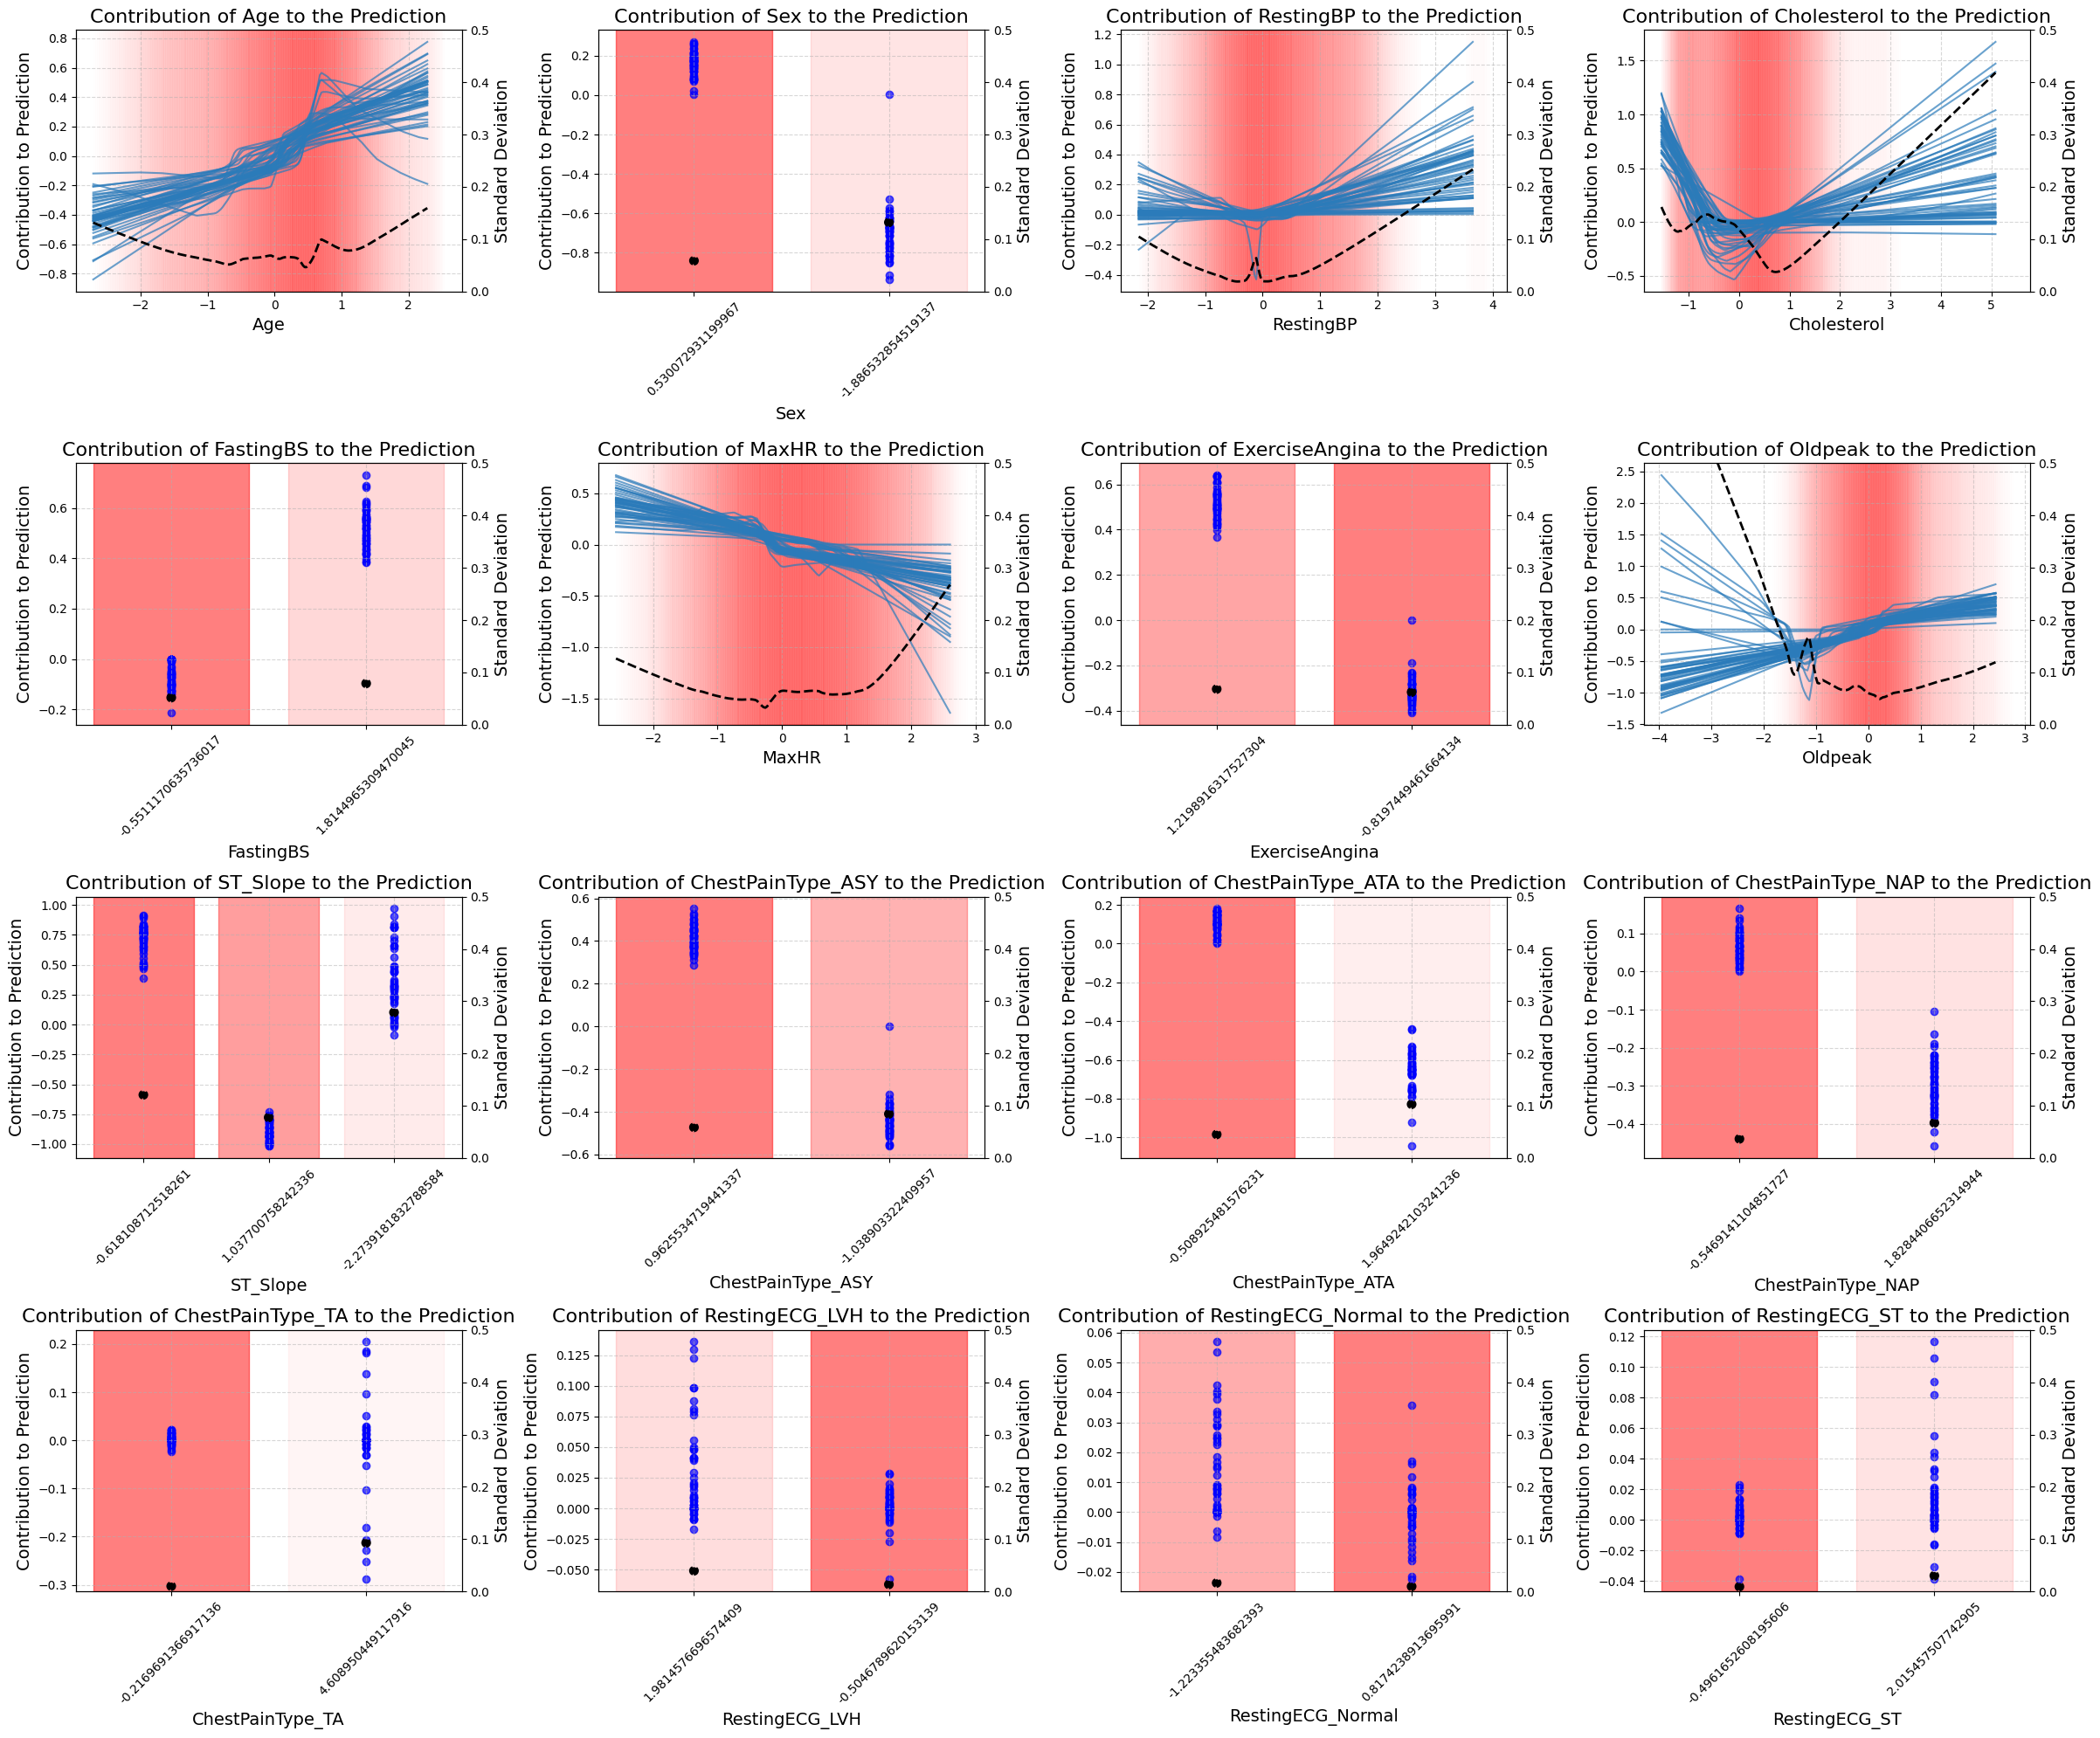

In [23]:
feature_names = X_test.columns
num_features = len(feature_names)
n_cols = 4  # Change if you want more/less columns
n_rows = int(np.ceil(num_features / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows))
axes = axes.flatten()
for i, feature_name in enumerate(feature_names):
    ax1 = axes[i]

    values = X_test[feature_name]


    if feature_name in numerical_columns:
        # Numerical Feature: Use KDE
        values_np = values.values
        kde = gaussian_kde(values_np)
        xs = torch.linspace(values_np.min(), values_np.max(), 200)
        density = kde(xs.numpy())
        density_norm = density / density.max()

        # Add shading
        bar_width = (xs[1] - xs[0]).item() * 10
        for x_val, shade in zip(xs, density_norm):
            ax1.axvspan(x_val.item(), x_val.item() + bar_width, color='red', alpha=0.07 * shade)

        # Plot NAM contributions
        xs_plot = xs
        all_ys = []
        for learner_ind in range(NUMBER_OF_LEARNERS):
            ys = model.models[learner_ind].feature_nns[i](xs_plot.unsqueeze(1)).detach().numpy().reshape(xs_plot.shape)
            all_ys.append(ys)
            ax1.plot(xs_plot, ys, c=sns.color_palette("Blues")[4], alpha=0.7)

    else:
        # Categorical Feature
        categories = values.unique()
        category_indices = torch.arange(len(categories)).float()
        all_ys = []

        # Dummy density based on value counts
        value_counts = values.value_counts(normalize=True)
        density = value_counts[categories].fillna(0).values
        density_norm = density / density.max()

        # Add shading for each category
        for j, (cat, shade) in enumerate(zip(categories, density_norm)):
            ax1.axvspan(j - 0.4, j + 0.4, color='red', alpha=0.5 * shade)

        # Evaluate model on each category (encoded)
        for learner_ind in range(NUMBER_OF_LEARNERS):
            # Encode category to one-hot or integer-based embedding index
            # Assume categories are passed through an embedding or ordinal encoder
            input_tensor = torch.tensor(categories).float()
            ys = model.models[learner_ind].feature_nns[i](input_tensor).detach().numpy().reshape(-1)
            all_ys.append(ys)
            ax1.scatter(category_indices, ys, c='blue', alpha=0.7)

        # Set xticks to category names
        ax1.set_xticks(category_indices)
        ax1.set_xticklabels(categories, rotation=45)

        xs_plot = category_indices

    ax1.set_title(f"Contribution of {feature_name} to the Prediction", fontsize=16)
    ax1.set_xlabel(f"{feature_name}", fontsize=14)
    ax1.set_ylabel("Contribution to Prediction", fontsize=14)
    ax1.grid(True, linestyle="--", alpha=0.5)

    # Standard deviation
    all_ys = np.stack(all_ys)
    std_ys = np.std(all_ys, axis=0)

    ax2 = ax1.twinx()
    if feature_name in numerical_columns:
        ax2.plot(xs_plot, std_ys, color='black', linestyle='--', linewidth=2, label='Std. Dev. Across Learners')
    else:
        ax2.scatter(xs_plot, std_ys, color='black', linestyle='--', linewidth=2, label='Std. Dev. Across Learners')
    ax2.set_ylabel("Standard Deviation", fontsize=14, color='black')
    ax2.set_ylim(0, 0.5)
    ax2.tick_params(axis='y', labelcolor='black')

fig.tight_layout()
plt.show()

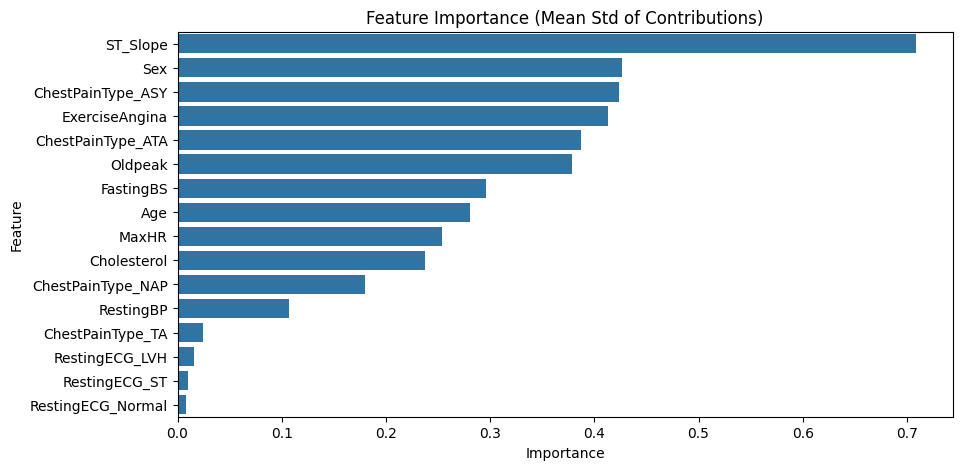

In [24]:


# Example: compute std of contribution functions across the domain
feature_importances = []
for i, feature_name in enumerate(feature_names):
    values = X_test[feature_name]
    if feature_name in numerical_columns:
        values_np = values.values
        xs = torch.linspace(values_np.min(), values_np.max(), 200)
    else:
        xs = torch.tensor(values.unique()).float()
    all_ys = []
    for learner_ind in range(NUMBER_OF_LEARNERS):
        ys = model.models[learner_ind].feature_nns[i](xs).detach().numpy().reshape(-1)
        all_ys.append(ys)
    std_across_x = np.std(np.stack(all_ys), axis=1).mean()  # Avg std across x
    feature_importances.append((feature_name, std_across_x))

# Sort and plot
feature_importances.sort(key=lambda x: -x[1])
names, values = zip(*feature_importances)
plt.figure(figsize=(10, 5))
sns.barplot(x=values, y=names)
plt.title("Feature Importance (Mean Std of Contributions)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

In [7]:
print('----[TRAIN RESULTS]----')
pred = model.predict_proba(X)
print('F1 score:', sk_metrics.f1_score(y, pred > 0.5))
print('ROC AUC:', sk_metrics.roc_auc_score(y, pred))
print('----[TEST RESULTS]----')
pred = model.predict_proba(X_test)
print('F1 score:', sk_metrics.f1_score(y_test, pred > 0.5))
print('ROC AUC:', sk_metrics.roc_auc_score(y_test, pred))

----[TRAIN RESULTS]----
F1 score: 0.8891625615763546
ROC AUC: 0.9414557908590572
----[TEST RESULTS]----
F1 score: 0.8711111111111111
ROC AUC: 0.9023341523341524
